In [1]:
import numpy as np

In [132]:
# test data
ti = np.array([0.0, 0.9, 2.1, 3.0, 4.5, 5.5, 10.])
yi = np.array([0.0, 1.0, 1.5, 2.7, 5.0, 6.0, 7.0])
tension = 1.0

In [133]:
# solve the tri-diagonal system needed to interpolate
ni = len(yi)
dt = np.diff(ti)
assert(np.min(dt) > 0)
sigma = tension / np.max(dt)
dydt = np.diff(yi)/dt
tau = sigma * dt
s1 = 1.0 / (dt * sigma**2)
s2 = -2*dt*np.exp(-tau)/(tau*np.expm1(-2*tau))

n = ni - 2
w = dt / (tau*np.tanh(tau)) - s1
sdiag = s1[1:n] - s2[1:n]
diag = w[:n] + w[1:] 
b = np.diff(dydt)
T = np.diag(sdiag,-1) + np.diag(sdiag,1) + np.diag(diag)
ypps = np.zeros(ni)
ypps[1:1+n] = np.linalg.solve(T,b)

# interpolation function uses ti, yi, dt, tau, sigma, ypps
def tension_interp(t):
    res = np.zeros(np.shape(t))
    res[np.where(t<=ti[0])] = yi[0]
    res[np.where(t>=ti[-1])] = yi[-1]
    gi = np.where( (ti[0] < t) & (t < ti[-1]) )
    tg = t[gi]
    ii = np.array([np.argmin(ti<tx) for _, tx in enumerate(tg)])
    u = (ti[ii] - tg) / dt[ii-1]
    v = 1-u
    den = -np.expm1(-2*tau[ii-1])
    eum = np.exp( (u-1)*tau[ii-1] )
    eup = np.exp(-(u+1)*tau[ii-1] )
    evm = np.exp( (v-1)*tau[ii-1] )
    evp = np.exp(-(v+1)*tau[ii-1] )
    
    sig2 = sigma**2
    p = ( ((eum - eup) / den) - u ) / sig2
    q = ( ((evm - evp) / den) - v ) / sig2
    g = ypps[ii-1]*p + ypps[ii]*q
    res[gi] = u*yi[ii-1] + v*yi[ii] + g
    
    return res
    

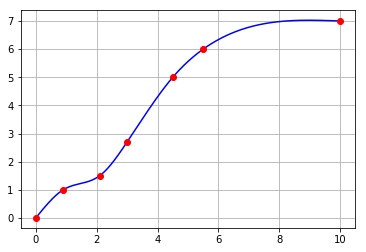

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

t = np.linspace(0,10,200)
plt.plot(t, tension_interp(t),'b-')
plt.plot(ti, yi, 'ro')
plt.grid(True)
plt.show()

In [50]:
N = ni - 2
subDiag = np.zeros(N)
superDiag = np.zeros(N)
diag = np.zeros(N)
b = np.zeros(N)

diag[0] = dt[0] / (tau[0]*np.tanh(tau[0])) - s1[0]
D = dt[1] / (tau[1]*np.tanh(tau[1])) - s1[1]
diag[0] += D
b[0] = dydt[1] - dydt[0]
for i in range(1,n):
    b[i] = dydt[i+1] - dydt[i]
    diag[i] = D
    D = dt[i+1] / (tau[i+1]*np.tanh(tau[i+1])) - s1[i+1]
    diag[i] += D
    subDiag[i] = s1[i] - s2[i]
    superDiag[i-1] = subDiag[i]
    
T = np.diag(subDiag,-1)[1:,1:] + np.diag(diag) + np.diag(superDiag,1)[0:N,0:N]
print(T)
print(b)
print(np.linalg.solve(T,b))

[[ 0.67694934  0.18601239  0.          0.          0.        ]
 [ 0.18601239  0.67694934  0.14393064  0.          0.        ]
 [ 0.          0.14393064  0.76259121  0.22362281  0.        ]
 [ 0.          0.          0.22362281  0.79340999  0.15841204]
 [ 0.          0.          0.          0.15841204  1.3313118 ]]
[-0.69444444  0.91666667  0.2        -0.53333333 -0.77777778]
[-1.50520198  1.74451303  0.10912167 -0.60058318 -0.51275604]
